In [0]:
'''
Copyright

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük
az alábbi szerzőt értesíteni.

2019 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu)


# adatok eredetileg innen:
#   https://www.kaggle.com/mlg-ulb/creditcardfraud/data
# források:
#   https://hub.packtpub.com/using-autoencoders-for-detecting-credit-card-fraud-tutorial/
#   https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
#   https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6
'''



In [0]:
!wget smartlab.tmit.bme.hu/csapo/dl/creditcard.csv

--2019-11-20 12:23:22--  http://smartlab.tmit.bme.hu/csapo/dl/creditcard.csv
Resolving smartlab.tmit.bme.hu (smartlab.tmit.bme.hu)... 152.66.246.149
Connecting to smartlab.tmit.bme.hu (smartlab.tmit.bme.hu)|152.66.246.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 143.84M  32.4MB/s    in 4.7s    

2019-11-20 12:23:27 (30.8 MB/s) - ‘creditcard.csv’ saved [150828752/150828752]



In [0]:
!ls -al

total 147316
drwxr-xr-x 1 root root      4096 Nov 20 12:23 .
drwxr-xr-x 1 root root      4096 Nov 20 09:23 ..
drwxr-xr-x 1 root root      4096 Nov 18 16:15 .config
-rw-r--r-- 1 root root 150828752 Sep 19 23:04 creditcard.csv
drwx------ 3 root root      4096 Nov 20 09:39 drive
drwxr-xr-x 1 root root      4096 Nov 15 16:31 sample_data


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# adatok beolvasása pandas dataframe-be
df = pd.read_csv('creditcard.csv')

In [0]:
# először nézzük át, mi van az adatokban!

In [0]:
df.shape

(284807, 31)

In [0]:
# V1...V28: tömörített, anonimizált adat
# Time: időbélyeg
# Amount: összeg
# Class: osztály (0: normál, 1: csalás)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [0]:
# van-e benne hiányzó érték
df.isnull().values.any()

False

In [0]:
# normál / csalás tranzakciók aránya
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print('normál:', normal.shape, 'csalás:', frauds.shape)

normál: (284315, 31) csalás: (492, 31)


In [0]:
# mennyire különböző a normál / csalás tranzakciók összege?
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

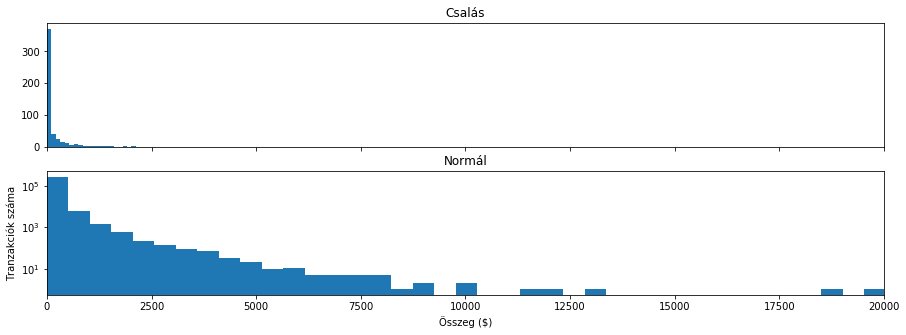

In [0]:
# mennyire különböző a normál / csalás tranzakciók összege?  - hisztogramon ábrázolva
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.hist(frauds.Amount, bins = 20)
ax1.set_title('Csalás')

ax2.hist(normal.Amount, bins = 50)
ax2.set_title('Normál')
plt.xlabel('Összeg ($)')
plt.ylabel('Tranzakciók száma')
plt.xlim((0, 20000))
plt.yscale('log')

Text(0, 0.5, 'Összeg')

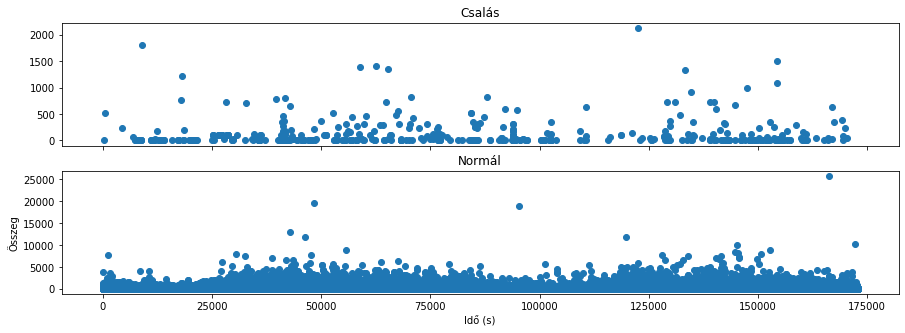

In [0]:
# csalás tranzakciók: látszik valamilyen mintázat időben?
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Csalás')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normál')

plt.xlabel('Idő (s)')
plt.ylabel('Összeg')


In [0]:
# adatok átrendezése: időtől nem függ
df = df.drop('Time',axis=1)

In [0]:
X = df.drop('Class',axis=1).values
y = df['Class'].values

In [0]:
X -= X.min(axis=0)
X /= X.max(axis=0)


In [0]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.1)


In [0]:
X_train.shape

(256326, 29)

In [0]:
data_in = Input(shape=(29,))
encoded = Dense(2,activation='tanh')(data_in)
decoded = Dense(29,activation='sigmoid')(encoded)
autoencoder = Model(data_in,decoded)

In [0]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [0]:
autoencoder.fit(X_train, X_train, epochs = 5, batch_size=128, validation_data=(X_test,X_test))

Train on 256326 samples, validate on 28481 samples
Epoch 1/5
256326/256326 [==============================] - 8s 32us/step - loss: 0.0084 - val_loss: 0.0023
Epoch 2/5
256326/256326 [==============================] - 8s 30us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/5
256326/256326 [==============================] - 8s 30us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/5
256326/256326 [==============================] - 8s 30us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/5
256326/256326 [==============================] - 8s 30us/step - loss: 0.0017 - val_loss: 0.0017


In [0]:
pred = autoencoder.predict(X_test[0:10])

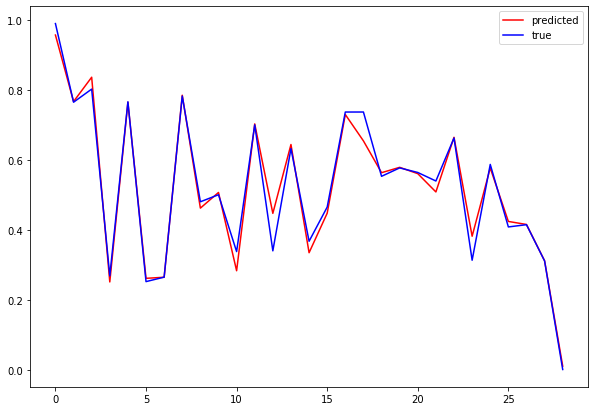

In [0]:
fig = plt.figure(figsize=(10,7))
plt.plot(pred[9], 'r')
plt.plot(X_test[9], 'b')
plt.legend(['predicted', 'true'])

In [0]:
encoder = Model(data_in,encoded)
enc = encoder.predict(X_test)


In [0]:
enc[0]

array([0.9993241, 0.9995096], dtype=float32)

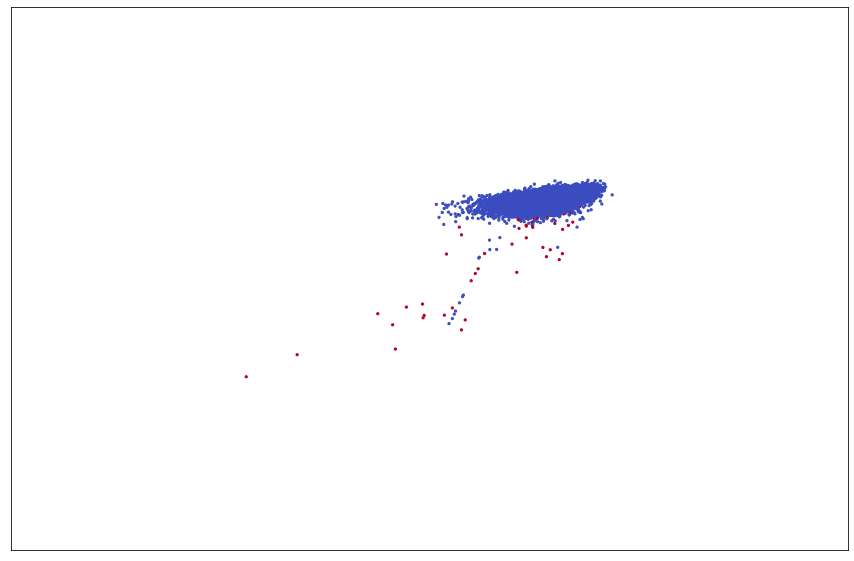

In [0]:
# a 'csalás' (piros) adatok valóban elkülönülnek a 'normál' adatoktól a 2D reprezentáció során

fig = plt.figure(figsize=(15,10))
scatter =plt.scatter(enc[:,0],enc[:,1],c=y_test, cmap='coolwarm', s=5.0)
scatter.axes.get_xaxis().set_visible(False)
scatter.axes.get_yaxis().set_visible(False)